In [1]:
import paths
import yaml
import os
import copy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, collections as mc, patches as mpatches, cm, ticker, colors
from cklemap.sdfs.geom_mrst import GeomMRST
from cklemap.sdfs.bc_mrst import BCMRST
from cklemap.sdfs.tpfa import TPFA
from time import perf_counter
import cklemap.ckli.ckliest_h1reg as ckliest
import h5py
import GPy

In [ ]:
amps = True
if amps:
    from cklemap.sdfs.darcy import DarcyExp
    from cklemap.sdfs.dasa import DASAExpLMAMPS
    import cklemap.ckli.mapest as mapest
else:
    from cklemap.sdfs.darcy_old import DarcyExp
    from cklemap.sdfs.dasa_old import DASAExpLM
    import cklemap.ckli.mapest_old as mapest

In [2]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    #fig.colorbar(p, ax=ax)
    return p

In [3]:
# Parameters
res_fac = 1
resolution = '16x'
resolution_ref = '1x'
num_trials = 10
seed = 0
#Nuobs = 50
NYobs = 100
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nuxi = 1000
Nens = 5000
beta_ckli = 1e1
Ygamma_ckli = 1e-4
ugamma_ckli = 1e-4
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
lsq_method = 'trf'
run_MAP = True
data_path = '../data/'
results_path = '../results/'
figures_path = '../figures/'
geom_filename = data_path + f'geom/geom_{resolution}.mat'
geom_ref_filename= data_path + f'geom/geom_{resolution_ref}.mat'
bc_filename = data_path + f'bc/bc_{resolution}.mat'
conduct_filename = data_path + f'RF1/conduct_log_RF1_{resolution_ref}.mat'
well_cells_filename = data_path + f'well_cells/well_cells_{resolution}.mat'
yobs_filename = data_path + f'yobs/yobs_{NYobs}_{resolution}.npy'
ref = f'Yref=orig_interpolated'

In [4]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
if resolution_ref != resolution:
    geom_ref = GeomMRST(geom_ref_filename)
else:
    geom_ref = geom
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)

In [5]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]
patches_ref = [mpatches.Polygon(v, closed=True) for v in geom_ref.nodes.coords.T[geom_ref.cells.nodes.T, :]]

In [6]:
# Observations
rs = npr.RandomState(seed)
Nc = geom.cells.num
Ninf = geom.faces.num_interior

with h5py.File(conduct_filename, 'r') as f:
    Yref_orig = f.get('conduct_log')[:].ravel() - Yfac

In [7]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [8]:
if os.path.exists(yobs_filename):
    print(f'reading {yobs_filename}')
    iYobs = np.load(yobs_filename)
else:
    print(f'iYobs randomly generated and saved to {yobs_filename}')
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False)) for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
iYobs = iYobs[0]
iYlearn = geom_ref.cellsContain(geom.cells.centroids.T[iYobs])
Ylearn = Yref_orig[iYlearn]

iYobs randomly generated and saved to hanford_data/yobs_100_16x.npy


ValueError: operands could not be broadcast together with shapes (10,1,1,100,2) (1,1475,4,2) 

In [9]:
klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
mYlearn = GPy.models.GPRegression(geom_ref.cells.centroids[:,iYlearn].T, Ylearn[:, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
mYlearn.optimize(messages=True, ipython_notebook=False)
mYref = GPy.models.GPRegression(geom_ref.cells.centroids.T, Yref_orig[:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
Yref, CYref = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0004   2.160626e+02   3.819903e+04 
    00s04  0008   1.649956e+02   9.210609e+02 
    00s07  0014   1.496248e+02   5.398346e-01 
    00s10  0020   1.487627e+02   2.502000e-01 
    00s14  0027   1.487509e+02   1.720144e-03 
    00s16  0030   1.487508e+02   7.798644e-05 
    00s19  0037   1.487508e+02   6.788096e-07 
    00s24  0055   1.487508e+02   6.911792e-07 
Runtime:     00s24
Optimization status: Converged



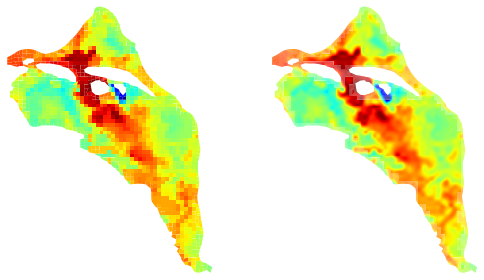

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plot_patch(patches_ref, Yref_orig + Yfac, fig, ax[0], None, 'Yref', 0, 12)
plot_patch(patches, Yref + Yfac, fig, ax[1], None, 'Yref_4x', 0, 12)
fig.tight_layout()
fig.savefig(figures_path + f'Yref/Yref_{resolution_ref=}_NY={NYobs}_{resolution}.pdf', dpi=300)

In [11]:
# Reference pressure field
prob = DarcyExp(TPFA(geom, bc), None)
uref = prob.solve(Yref)

# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1
uobs = uref[iuobs]
Nuobs = iuobs.size

In [12]:
exp = f'NY={NYobs}_Nu={iuobs.size}_NYlearn={NYlearn}_Nuxi={Nuxi}_NYxi={NYxi}_beta={beta_ckli}_gamma={ugamma_ckli}_h1reg_{ref}'
print(exp)

NY=100_Nu=459_NYlearn=100_Nuxi=1000_NYxi=1000_beta=10.0_gamma=0.0001_h1reg_Yref=orig_interpolated


In [13]:
timings = np.zeros(6)
nfevs = np.zeros(3, dtype=int)
rel_errors = np.zeros(4)
abs_errors = np.zeros(4)

Yobs = Yref[iYobs]

In [14]:
ts = perf_counter()
klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYobs].T, Yobs[:, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
mYlearn.optimize(messages=True, ipython_notebook=False)
mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs].T, Yobs[:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
Ypred, CYpred = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
timings[0] = perf_counter() - ts

print(f"GPR: {timings[0] : g} s")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   4.345577e+03           nan 
    00s01  0002   2.277742e+02   4.139909e+04 
    00s04  0007   1.856202e+02   1.035463e+03 
    00s06  0011   1.662485e+02   1.853810e+01 
    00s06  0012   1.659352e+02   2.044464e+01 
    00s09  0017   1.658411e+02   3.465631e-13 
    00s09  0018   1.658411e+02   3.465631e-13 
Runtime:     00s09
Optimization status: Converged

GPR:  92.8154 s


In [15]:
# Compute GP model for u
ts = perf_counter()
umean, Cu = ckliest.smc_gp(Ypred, CYpred, Nens, prob, rs)
upred, Cupred = ckliest.gpr(umean, Cu, uobs, iuobs)
timings[1] = perf_counter() - ts

print(f"Monte Carlo: {timings[1] : g} s")

Monte Carlo:  991.99 s


In [16]:
# PICKLE models
Ym = Ypred
CYm = CYpred
um = umean #or change to upred
Cum = Cu #or change to Cupred

rel_errors[0] = rl2e(Ym, Yref)
abs_errors[0] = infe(Ym, Yref)

print(f"Monte Carlo: {timings[1] : g} s")
print(f"GPR\trelative L2 error: {rel_errors[0] : g}")
print(f"GPR\tabsolute infinity error: {abs_errors[0] : g}")

Monte Carlo:  991.99 s
GPR	relative L2 error:  0.534009
GPR	absolute infinity error:  5.75292


In [17]:
ts = perf_counter()
PsiY, LambdaY = ckliest.KL_via_eigh(CYm, NYxi)
Psiu, Lambdau = ckliest.KL_via_eigh(Cum, Nuxi)
timings[2] = perf_counter() - ts

print(f"eigendecomposition: {timings[2] : g} s")

eigendecomposition:  913.748 s


In [18]:
# PICKLE estimate
Lreg = mapest.compute_Lreg(geom)
ssv = None

res = ckliest.LeastSqRes(NYxi, Ym, PsiY, Nuxi, um, Psiu, prob, ugamma_ckli, Ygamma_ckli, res_fac, Lreg, iuobs, uobs, iYobs, Yobs, beta_ckli, ssv=ssv)
x0 = np.zeros(Nuxi + NYxi)
    
ts = perf_counter()
sol = spo.least_squares(res.val, x0, jac=res.jac, method=lsq_method, verbose=2)
ckli_status = sol.status
timings[3] = perf_counter() - ts
nfevs[0] = sol.nfev
print(f'CKLI optimality: {sol.optimality : g}')

uxi = sol.x[:Nuxi]
Yxi = sol.x[Nuxi:]
uest = um + Psiu @ uxi
Yest = Ym + PsiY @ Yxi

rel_errors[1] = rl2e(Yest, Yref)
abs_errors[1] = infe(Yest, Yref)

print(f"PICKLE: {timings[3] : g} s")
print(f"PICKLE\trelative L2 error: {rel_errors[1] : g}")
print(f"PICKLE\tabsolute infinity error: {abs_errors[1] : g}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9333e+03                                    2.95e+03    
       1              2         5.6336e+02      1.37e+03       1.00e+00       3.25e+02    
       2              3         1.3948e+02      4.24e+02       2.00e+00       3.18e+01    
       3              4         2.2915e+01      1.17e+02       4.00e+00       1.89e+00    
       4              5         3.0359e+00      1.99e+01       8.00e+00       2.19e+01    
       5              7         1.5499e+00      1.49e+00       4.00e+00       7.87e-01    
       6              8         8.6709e-01      6.83e-01       8.00e+00       5.95e+00    
       7              9         5.9182e-01      2.75e-01       1.60e+01       8.23e+00    
       8             11         4.7794e-01      1.14e-01       4.00e+00       2.99e+00    
       9             12         4.5146e-01      2.65e-02       8.00e+00       8.93e-01    

In [21]:
if run_MAP:
# MAP H1 estimate
    # MAP H1 estimate
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs, iYobs, Yobs, gamma_map, Lreg) # H1 regularization
    if amps:
        prob.setup_amps(iuobs)
        dasa = DASAExpLMAMPS(prob.partial_solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y, prob.u_sens_p, (Nuobs + NYobs + Ninf, Nc), Nuobs)
    else:
        dasa = DASAExpLM(prob.solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y)
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(Nc), jac=dasa.grad, method=lsq_method, verbose=2)
    Yest_MAPH1 = sol.x
    
    MAP_status = sol.status
    timings[4] = perf_counter() - ts
    nfevs[1] = sol.nfev
    print(f'MAP status: {MAP_status}, message: {sol.message}')

rel_errors[2] = rl2e(Yest_MAPH1, Yref)
abs_errors[2] = infe(Yest_MAPH1, Yref)

print(f"MAP: {timings[4] : g} s")
print(f"MAP\trelative L2 error: {rel_errors[2] : g}")
print(f"MAP\tabsolute infinity error: {abs_errors[2] : g}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0239e+04                                    1.20e+03    


ValueError: Too large work array required -- computation cannot be performed with standard 32-bit LAPACK.

In [ ]:
np.savetxt(results_path + f'iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(results_path + f'timings/timings_{exp}.txt', timings)
np.savetxt(results_path + f'nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(results_path + f'rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(results_path + f'abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(results_path + f'YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(results_path + f'YPICKLE/YPICKLE_{exp}.txt', Yest_MAPH1)
np.savetxt(results_path + f'YMAP/YMAP_{exp}.txt', Yest_MAPH1)